In [14]:
#basic Libraries
import pandas as pd
import shap
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')


#preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

#metrics
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

#algorithms 
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

#hyptertuning
from sklearn.model_selection import RandomizedSearchCV

#Scalers 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [2]:
# load JS visualization code to notebook
shap.initjs()

In [3]:
df = pd.read_csv('final_water.csv', index_col = 0)
df = df.set_index('new_date')

In [4]:
#Select desired columns
df = df.loc[:, ['areaacres', 'za_mean', 'lc_21',
       'lc_22', 'lc_23', 'lc_24', 'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52',
       'lc_71', 'lc_81', 'lc_82', 'lc_90', 'lc_95', 'week', 'airtemp_narr', 'precip3_narr',
       'humidity_narr', 'cl_cover_narr', 'sfc_runoff', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr', 'of_dist', 'tn', 'total Nitrogen Oxide in year']]

In [5]:
#Preprocessing 
knnimputer = KNNImputer(n_neighbors=2)
ohe = OneHotEncoder(handle_unknown='ignore')
scaler_rob = RobustScaler()
scaler_std = StandardScaler()

#StandardScaler worked best before but try RobustScaler 
knn_impute_scale1 = make_pipeline(knnimputer, scaler_rob)
knn_impute_scale2 = make_pipeline(knnimputer, scaler_std)

In [6]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels = 'tn', axis = 1), df['tn'], test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape

((11653, 28), (4995, 28))

In [7]:
#robust scaler column transformer xgboost
ct = make_column_transformer(
    (knn_impute_scale1, ['areaacres', 'lc_23', 'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52',
       'lc_71', 'lc_81', 'lc_82', 'lc_90', 'lc_95', 'week', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'sfc_runoff', 'windspeed_narr',
       'precip48_narr', 'of_dist', 'total Nitrogen Oxide in year']),
    remainder='passthrough')

In [8]:
#standard scaler column transformer randomforest
ct2 = make_column_transformer(
    (knn_impute_scale2, ['areaacres', 'lc_22', 'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52',
       'lc_71', 'lc_81', 'lc_82', 'lc_90', 'lc_95', 'week', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'sfc_runoff', 'windspeed_narr',
       'precip48_narr', 'of_dist', 'total Nitrogen Oxide in year']),
    remainder='passthrough')

In [9]:
#xgboost
X_train1 = X_train.drop(columns = ['za_mean', 'lc_21', 'lc_22', 'lc_24', 'precip24_narr',
                                  'cl_cover_narr', 'wdirection_narr'])

X_test1 = X_test.drop(columns = ['za_mean', 'lc_21', 'lc_22', 'lc_24', 'precip24_narr',
                                  'cl_cover_narr', 'wdirection_narr'])

In [10]:
#Random Forest
X_train2 = X_train.drop(columns = ['za_mean', 'lc_21', 'lc_23', 'lc_24', 'precip24_narr',
                                  'cl_cover_narr', 'wdirection_narr'])

X_test2 = X_test.drop(columns = ['za_mean', 'lc_21', 'lc_23', 'lc_24', 'precip24_narr',
                                  'cl_cover_narr', 'wdirection_narr'])


{'xgbregressor__n_estimators': 640, 'xgbregressor__min_child_weight': 6, 'xgbregressor__max_samples': 440, 'xgbregressor__max_depth': 30, 'xgbregressor__importance_type': 'weight'}

{'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_samples': 850, 'randomforestregressor__max_depth': 200}

In [11]:
#Pipeline Creation 
xgb = xgb.XGBRegressor(random_state = 0, n_jobs = -1, n_estimators = 640, max_samples = 440,
                      max_depth = 30, min_child_weight = 6, importance_type = 'weight')
rf = RandomForestRegressor(random_state = 0, n_jobs = -1, n_estimators = 800, max_samples = 850,
                          max_depth = 200, min_samples_split = 6, min_samples_leaf =2)

pipeline1 = make_pipeline(ct,xgb)
pipeline2 = make_pipeline(ct2, rf)

In [12]:
#pipeline fitting Robust Scaler xgb
pipeline1.fit(X_train1, y_train);

[01:27:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [15]:
#pipeline prediction 
y_pred1 = pipeline1.predict(X_test1)
#Results
print(r2_score(y_test, y_pred1))
print(explained_variance_score(y_test, y_pred1))
print(np.sqrt(mean_squared_error(y_test, y_pred1)))

0.8105229500897968
0.8105250019170382
1.2749355880797621


In [16]:
#pipeline fitting standard scaler RandomForest
pipeline2.fit(X_train2, y_train);

In [18]:
#pipeline prediction 
y_pred2 = pipeline2.predict(X_test2)
#Results
print(r2_score(y_test, y_pred2))
print(explained_variance_score(y_test, y_pred2))
print(np.sqrt(mean_squared_error(y_test, y_pred2)))

0.6249312152652691
0.6249321422043841
1.7937643876232374


In [19]:
# Explaining the model's predictions using SHAP values
explainer1 = shap.TreeExplainer(pipeline1['xgbregressor'])
shap_values1 = explainer1.shap_values(X_train1)

In [20]:
shap_value1_df = pd.DataFrame(shap_values1)
shap_value1_df.to_csv('shap_value1.csv')

In [27]:
# Explaining the model's predictions using SHAP values
explainer2= shap.TreeExplainer(pipeline2['randomforestregressor'])
shap_values2 = explainer2.shap_values(X_train2)

In [ ]:
shap_value2_df = pd.DataFrame(shap_values2)
shap_value2_df.to_csv('shap_value2.csv')

In [ ]:
###Visualizations###

In [ ]:
#XgBoost

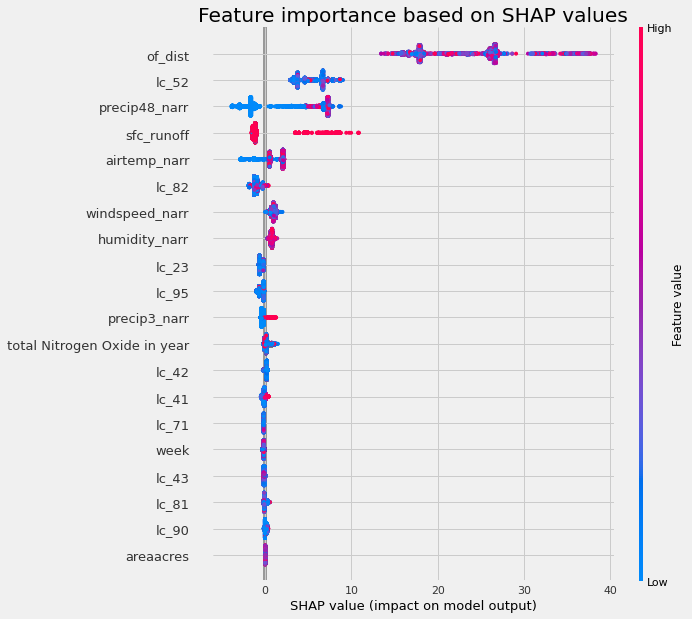

In [21]:
plt.title('Feature importance based on SHAP values')
shap.summary_plot(shap_values1, X_train1)

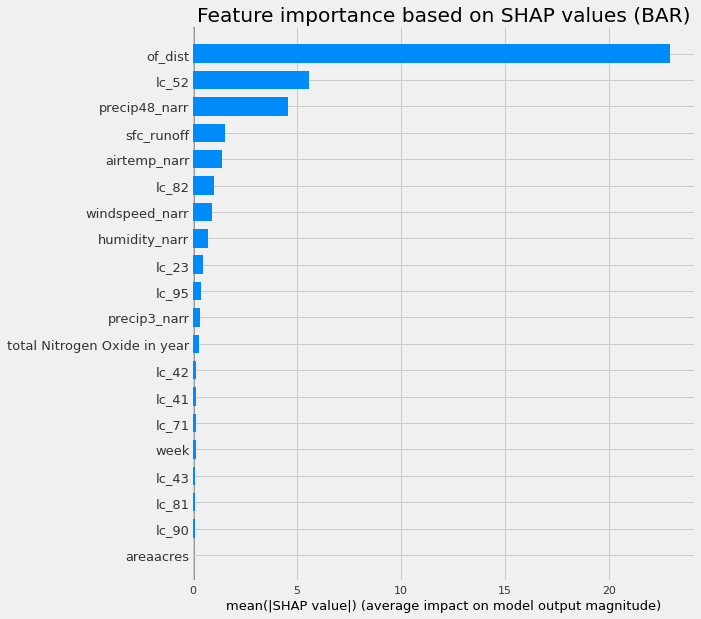

In [22]:
plt.title('Feature importance based on SHAP values (BAR)')
shap.summary_plot(shap_values1, X_train1, plot_type = 'bar')

In [23]:
shap.force_plot(explainer1.expected_value, shap_values1[0,:], X_train1.iloc[0,:])

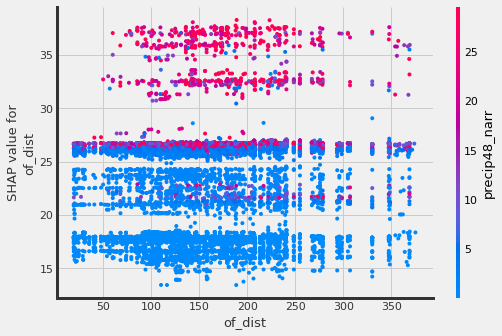

In [24]:
#create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('of_dist', shap_values1, X_train1)

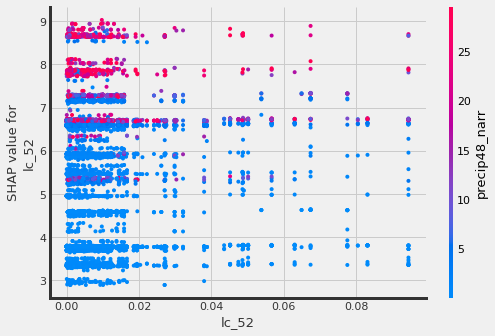

In [25]:
#create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('lc_52', shap_values1, X_train1)

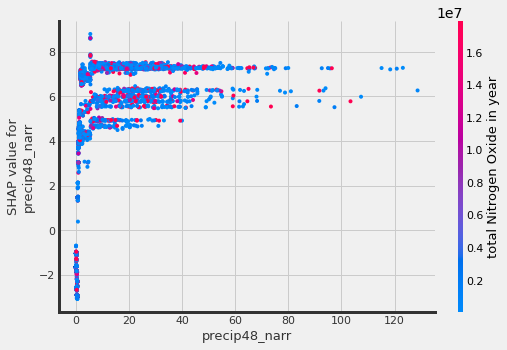

In [26]:
#create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('precip48_narr', shap_values1, X_train1)

In [ ]:
#RandomForest

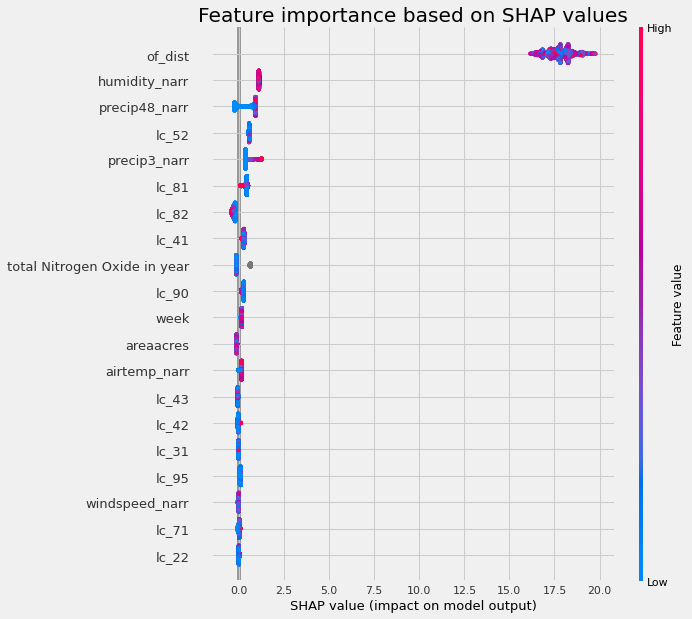

In [28]:
plt.title('Feature importance based on SHAP values')
shap.summary_plot(shap_values2, X_train2)

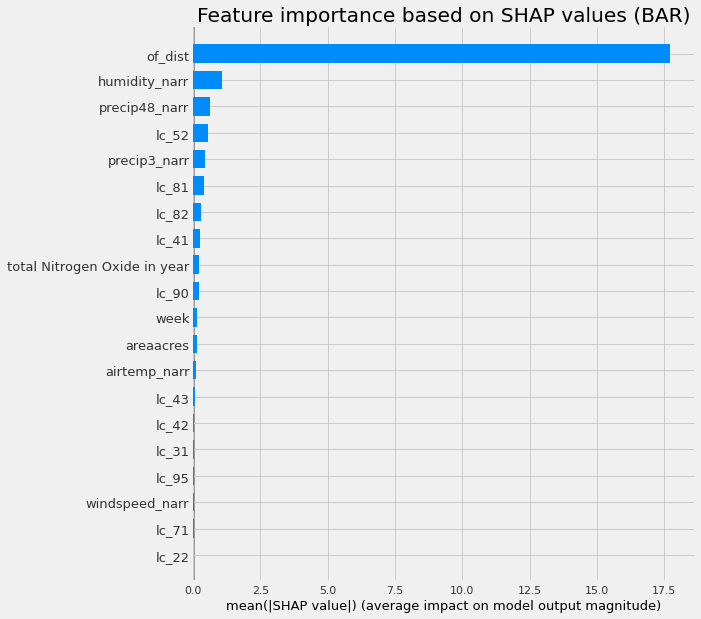

In [29]:
plt.title('Feature importance based on SHAP values (BAR)')
shap.summary_plot(shap_values2, X_train2, plot_type = 'bar')

In [30]:
shap.force_plot(explainer2.expected_value, shap_values2[0,:], X_train2.iloc[0,:])

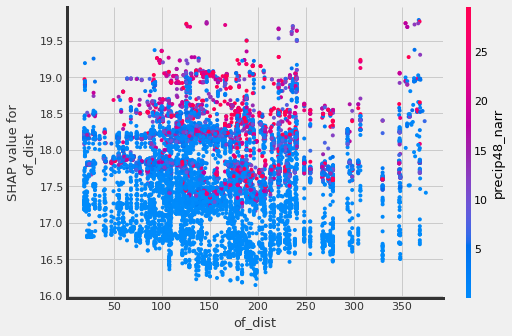

In [31]:
#create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('of_dist', shap_values2, X_train2)

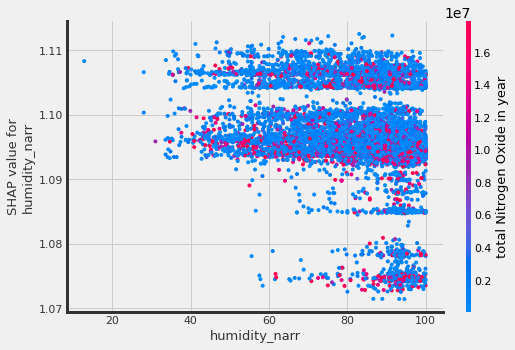

In [33]:
#create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('humidity_narr', shap_values2, X_train2)

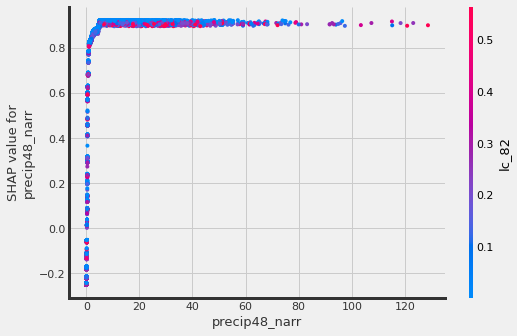

In [34]:
#create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('precip48_narr', shap_values2, X_train2)